## Оценка результатов A/B-теста

__Цель исследования:__

Проверка корректности проведения A/B-теста и анализ полученных результатов.

__Техническое задание__

Название теста: recommender_system_test ;

Группы: А (контрольная), B (новая платёжная воронка);

Дата запуска: 2020-12-07;

Дата остановки набора новых пользователей: 2020-12-21;

Дата остановки: 2021-01-04;

Ожидаемое количество участников теста: 15% новых пользователей из региона EU;

Назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;

Ожидаемый эффект: за 14 дней с момента регистрации в системе пользователи покажут улучшение каждой метрики не менее, чем на 5 процентных пунктов:
- конверсии в просмотр карточек товаров — событие product_page
- просмотры корзины — product_cart
- покупки — purchase.

__Описание данных__

/datasets/ab_project_marketing_events.csv — календарь маркетинговых событий на 2020 год;

Структура файла:
- name — название маркетингового события;
- regions — регионы, в которых будет проводиться рекламная кампания;
- start_dt — дата начала кампании;
- finish_dt — дата завершения кампании.

/datasets/final_ab_new_users.csv — все пользователи, зарегистрировавшиеся в интернет-магазине в период с 7 по 21 декабря 2020 года;

Структура файла:
- user_id — идентификатор пользователя;
- first_date — дата регистрации;
- region — регион пользователя;
- device — устройство, с которого происходила регистрация.

/datasets/final_ab_events.csv — все события новых пользователей в период с 7 декабря 2020 по 4 января 2021 года;

Структура файла:
- user_id — идентификатор пользователя;
- event_dt — дата и время события;
- event_name — тип события;
- details — дополнительные данные о событии. Например, для покупок, purchase, в этом поле хранится стоимость покупки в долларах.

/datasets/final_ab_participants.csv — таблица участников тестов.

Структура файла:
- user_id — идентификатор пользователя;
- ab_test — название теста;
- group — группа пользователя.

Наша работа будет состоять из 7 шагов:

1. Загрузка данных
2. Предобработка данных
3. Соответствие данный ТЗ
4. Продуктовая воронка
5. Исследовательский анализ данных
6. Оценка A/B-теста
7. Общий вывод и рекомендации 

В итоге работы мы оценим результат A/B-теста и напишем рекомендации к дальнейшей работе. 

## Загрузка данных и импорт необходимых библиотек.

In [1]:
#Аналитика
import pandas as pd
import numpy as np 
import datetime as dt
from datetime import datetime, timedelta
import math
import scipy.stats as stats
from scipy import stats as st

#Визуализация 
import seaborn as sns
import matplotlib.pyplot as plt
from plotly.graph_objs import Scatter, Figure, Layout
import plotly
import plotly.graph_objs as go
import plotly.express as px

# для игнорирования предупреждений
import warnings
warnings.filterwarnings('ignore')

# увеличим количество символов, которые можно показывать
pd.options.display.max_colwidth = 150
# выставляем ограничение на показ знаков после запятой
pd.options.display.float_format = '{:,.3f}'.format

In [2]:
#Откроем файлы.
try:
    marketing, users, events, participants  = (
        pd.read_csv('/datasets/ab_project_marketing_events.csv'),
        pd.read_csv('/datasets/final_ab_new_users.csv'),
        pd.read_csv('/datasets/final_ab_events.csv'),
        pd.read_csv('/datasets/final_ab_participants.csv'))

except:
    marketing, users, events, participants = (
        pd.read_csv('ab_project_marketing_events.csv'),
        pd.read_csv('final_ab_new_users.csv'),
        pd.read_csv('final_ab_events.csv'),
        pd.read_csv('final_ab_participants.csv'))

## Предобработка данных.

In [3]:
marketing

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11
5,Black Friday Ads Campaign,"EU, CIS, APAC, N.America",2020-11-26,2020-12-01
6,Chinese New Year Promo,APAC,2020-01-25,2020-02-07
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10
9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11


In [4]:
#Проверим на наличие пропусков и дубликатов 
display(marketing.duplicated().sum())
marketing.isna().sum()

0

name         0
regions      0
start_dt     0
finish_dt    0
dtype: int64

In [5]:
marketing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes


In [6]:
#Приведем столбцы start_dt и finish_dt к типу даты pandas в файле marketing
marketing['start_dt'] = pd.to_datetime(marketing['start_dt'])
marketing['finish_dt'] = pd.to_datetime(marketing['finish_dt'])
marketing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   name       14 non-null     object        
 1   regions    14 non-null     object        
 2   start_dt   14 non-null     datetime64[ns]
 3   finish_dt  14 non-null     datetime64[ns]
dtypes: datetime64[ns](2), object(2)
memory usage: 576.0+ bytes


In [7]:
users

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone
...,...,...,...,...
61728,1DB53B933257165D,2020-12-20,EU,Android
61729,538643EB4527ED03,2020-12-20,EU,Mac
61730,7ADEE837D5D8CBBD,2020-12-20,EU,PC
61731,1C7D23927835213F,2020-12-20,EU,iPhone


In [8]:
#Проверим на наличие пропусков и дубликатов 
display(users.duplicated().sum())
users.isna().sum()

0

user_id       0
first_date    0
region        0
device        0
dtype: int64

In [9]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     61733 non-null  object
 1   first_date  61733 non-null  object
 2   region      61733 non-null  object
 3   device      61733 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB


In [10]:
#Приведем столбец first_date к типу даты pandas в файле users
users['first_date'] = pd.to_datetime(users['first_date'])
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     61733 non-null  object        
 1   first_date  61733 non-null  datetime64[ns]
 2   region      61733 non-null  object        
 3   device      61733 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 1.9+ MB


In [11]:
users['first_date'].describe()

count                   61733
unique                     17
top       2020-12-21 00:00:00
freq                     6290
first     2020-12-07 00:00:00
last      2020-12-23 00:00:00
Name: first_date, dtype: object

In [12]:
#Согласно ТЗ у нас должны быть пользователи зарегестрированные с 7 по 21 декабря 2020 года.
#Поэтому уберем пользователей, которые зарегестрировались позде 21 декабря.
users = users[users['first_date'] <= '2020-12-21']
users['first_date'].describe()

count                   56470
unique                     15
top       2020-12-21 00:00:00
freq                     6290
first     2020-12-07 00:00:00
last      2020-12-21 00:00:00
Name: first_date, dtype: object

In [13]:
events

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.990
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.990
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.990
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.990
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.990
...,...,...,...,...
440312,245E85F65C358E08,2020-12-30 19:35:55,login,NaN
440313,9385A108F5A0A7A7,2020-12-30 10:54:15,login,NaN
440314,DB650B7559AC6EAC,2020-12-30 10:59:09,login,NaN
440315,F80C9BDDEA02E53C,2020-12-30 09:53:39,login,NaN


In [14]:
#Проверим на наличие пропусков и дубликатов 
display(events.duplicated().sum())
events.isna().sum()

0

user_id            0
event_dt           0
event_name         0
details       377577
dtype: int64

In [15]:
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-null  object 
 1   event_dt    440317 non-null  object 
 2   event_name  440317 non-null  object 
 3   details     62740 non-null   float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB


In [16]:
#Приведем столбец event_dt к типу даты pandas в файле events
events['event_dt'] = pd.to_datetime(events['event_dt'])
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     440317 non-null  object        
 1   event_dt    440317 non-null  datetime64[ns]
 2   event_name  440317 non-null  object        
 3   details     62740 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 13.4+ MB


In [17]:
events['event_dt'].describe()

count                  440317
unique                 267268
top       2020-12-14 18:54:55
freq                       10
first     2020-12-07 00:00:33
last      2020-12-30 23:36:33
Name: event_dt, dtype: object

In [18]:
participants

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test
...,...,...,...
18263,1D302F8688B91781,B,interface_eu_test
18264,3DE51B726983B657,A,interface_eu_test
18265,F501F79D332BE86C,A,interface_eu_test
18266,63FBE257B05F2245,A,interface_eu_test


In [19]:
#Проверим на наличие пропусков и дубликатов 
display(participants.duplicated().sum())
participants.isna().sum()

0

user_id    0
group      0
ab_test    0
dtype: int64

In [20]:
participants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB


Дубликатов и в данных нет. Пропуски присутстуют только в данных events, в столбце details. Рассмотрим его более подробно. 

In [21]:
events

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.990
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.990
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.990
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.990
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.990
...,...,...,...,...
440312,245E85F65C358E08,2020-12-30 19:35:55,login,NaN
440313,9385A108F5A0A7A7,2020-12-30 10:54:15,login,NaN
440314,DB650B7559AC6EAC,2020-12-30 10:59:09,login,NaN
440315,F80C9BDDEA02E53C,2020-12-30 09:53:39,login,NaN


In [22]:
events['event_name'].unique()

array(['purchase', 'product_cart', 'product_page', 'login'], dtype=object)

In [23]:
events[events['event_name'] == 'purchase'].head(5)

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.990
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.990
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.990
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.990
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.990


In [24]:
events[events['event_name'] == 'product_cart'].head(5)

,user_id,event_dt,event_name,details
62740,2E1BF1D4C37EA01F,2020-12-07 09:05:47,product_cart,NaN
62741,50734A22C0C63768,2020-12-07 13:24:03,product_cart,NaN
62742,5EB159DA9DC94DBA,2020-12-07 22:54:02,product_cart,NaN
62743,084A22B980BA8169,2020-12-07 15:25:55,product_cart,NaN
62744,0FC21E6F8FAA8DEC,2020-12-07 06:56:27,product_cart,NaN


In [25]:
events[events['event_name'] == 'product_page'].head(5)

,user_id,event_dt,event_name,details
125202,D72A72121175D8BE,2020-12-07 21:52:10,product_page,NaN
125203,F1C668619DFE6E65,2020-12-07 16:38:09,product_page,NaN
125204,2E1BF1D4C37EA01F,2020-12-07 09:05:46,product_page,NaN
125205,50734A22C0C63768,2020-12-07 13:24:02,product_page,NaN
125206,137119F5A9E69421,2020-12-07 14:13:58,product_page,NaN


In [26]:
events[events['event_name'] == 'login'].head(5)

,user_id,event_dt,event_name,details
250765,D72A72121175D8BE,2020-12-07 21:52:07,login,NaN
250766,F1C668619DFE6E65,2020-12-07 16:38:08,login,NaN
250767,2E1BF1D4C37EA01F,2020-12-07 09:05:46,login,NaN
250768,50734A22C0C63768,2020-12-07 13:24:02,login,NaN
250769,E1BDDCE0DAFA2679,2020-12-07 20:22:03,login,NaN


Мы видим, что детальная информация присудствует в 62740 случаях, когда происходит оплата. В остальных случаях , детали не указываются. Оставим все как есть. 

In [27]:
#Для удобства соеденим датафреймы users, events, participants,
#в которых информация о тестах, событиях и пользователях.
data_0 = events.merge(users, on='user_id', how='left')
data = data_0.merge(participants, on='user_id', how='left')
data.head(10)

,user_id,event_dt,event_name,details,first_date,region,device,group,ab_test
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.990,2020-12-07,N.America,iPhone,NaN,NaN
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.990,2020-12-07,EU,iPhone,NaN,NaN
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.990,2020-12-07,N.America,iPhone,NaN,NaN
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.990,2020-12-07,EU,iPhone,B,interface_eu_test
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.990,2020-12-07,EU,Android,NaN,NaN
5,831887FE7F2D6CBA,2020-12-07 06:50:29,purchase,4.990,2020-12-07,EU,Android,A,recommender_system_test
6,6B2F726BFD5F8220,2020-12-07 11:27:42,purchase,4.990,2020-12-07,EU,Android,NaN,NaN
7,BEB37715AACF53B0,2020-12-07 04:26:15,purchase,4.990,2020-12-07,EU,Android,NaN,NaN
8,B5FA27F582227197,2020-12-07 01:46:37,purchase,4.990,2020-12-07,N.America,Mac,NaN,NaN
9,A92195E3CFB83DBD,2020-12-07 00:32:07,purchase,4.990,2020-12-07,EU,Android,A,interface_eu_test


## Соответствие реальных данных техническому заданию. 

In [28]:
# Посмотрим какое количество групп в А/В-тесте.
data['group'].unique()

array([nan, 'B', 'A'], dtype=object)

На А/В-тесте у нас 2 группы. 

In [29]:
# Посморим данные за какие тесты у нас есть 
data.groupby(['ab_test','group']).agg({'user_id':'nunique'})

user_id
ab_test                 group         
interface_eu_test       A         5467
                        B         5383
recommender_system_test A         2747
                        B          928

По техническому заданию нам нужен тест по улучшению рекомендательной системы - recommender_system_test

In [30]:
#Проверим пересекаются ли пользователи в тестах 
interface_eu_test = data[data['ab_test'] == 'interface_eu_test']
recommender_system_test = data[data['ab_test'] == 'recommender_system_test']
interface_eu_test_participants = interface_eu_test['user_id'].unique()

In [31]:
#Проверим пересекаются ли пользователи в тестах 
data.groupby('user_id').agg({'ab_test' : 'nunique'}).query('ab_test>1').count()

ab_test    887
dtype: int64

У нас 887 пользователей, которые есть в обоих группах. Удалим их из данных. И создадим датафрейм только с нужным нам тестом recommender_system_test.

In [32]:
double_users = data.groupby('user_id').agg({'ab_test' : 'nunique'}).reset_index().query('ab_test>1')['user_id'].unique()


In [33]:
data = data.query('user_id not in @double_users')
recommender_system_test = data[data['ab_test'] == 'recommender_system_test']
recommender_system_test

,user_id,event_dt,event_name,details,first_date,region,device,group,ab_test
5,831887FE7F2D6CBA,2020-12-07 06:50:29,purchase,4.990,2020-12-07,EU,Android,A,recommender_system_test
17,3C5DD0288AC4FE23,2020-12-07 19:42:40,purchase,4.990,2020-12-07,EU,PC,A,recommender_system_test
58,49EA242586C87836,2020-12-07 06:31:24,purchase,99.990,2020-12-07,EU,iPhone,B,recommender_system_test
75,A640F31CAC7823A6,2020-12-07 18:48:26,purchase,4.990,2020-12-07,EU,PC,B,recommender_system_test
121,A9908F62C41613A8,2020-12-07 11:26:47,purchase,9.990,2020-12-07,EU,PC,B,recommender_system_test
...,...,...,...,...,...,...,...,...,...
446091,930EACAE048DFF45,2020-12-29 06:56:00,login,NaN,2020-12-20,EU,PC,A,recommender_system_test
446128,E5589EAE02ACD150,2020-12-29 22:17:08,login,NaN,2020-12-20,EU,Mac,A,recommender_system_test
446131,D21F0D4FDCD82DB2,2020-12-29 02:17:00,login,NaN,2020-12-20,EU,iPhone,A,recommender_system_test
446160,553BAE96C6EB6240,2020-12-29 14:09:14,login,NaN,2020-12-20,EU,Android,A,recommender_system_test


In [34]:
#Также проверим не пересекаются ли пользователи в тестовых группах A и B
recommender_system_test.groupby('user_id').agg({'group' : 'nunique'}).query('group>1').count()

group    0
dtype: int64

In [35]:
ab_test = recommender_system_test.groupby('group').agg({'user_id':'nunique'})
ab_test

,user_id
group,
A,2082
B,706


In [36]:
recommender_system_test['user_id'].nunique()

2788

Ожидаемое количество участников теста = 6000. Этот пункт не соответствует требованиям ТЗ.

Пользователи в тестовых группах не пересекаются. В тесте участвуют 2788 пользователей, количество клиентов по группам распределены неравномерно. Это может существенно повлиять на результат тестирования. 

In [37]:
#Проверим, соответствует ли временные рамки проекта. 
recommender_system_test['first_date'].describe()

count                   18804
unique                     15
top       2020-12-14 00:00:00
freq                     2641
first     2020-12-07 00:00:00
last      2020-12-21 00:00:00
Name: first_date, dtype: object

В наш тест должны попасть только те пользователи, которые были зарегистрированы в период набора новых пользователей в тест. Значит должен быть период с 2020-12-07 по 2020-12-21. Всё соответствует требованиям ТЗ. 

In [38]:
recommender_system_test['event_dt'].describe()

count                   18804
unique                  12607
top       2020-12-10 14:54:17
freq                        5
first     2020-12-07 00:16:00
last      2020-12-30 06:42:52
Name: event_dt, dtype: object

Последнее событие было совершено 2020-12-30, однако согласно ТЗ дата остановки: 2021-01-04. Этот пункт не соответствует требованиям ТЗ. 

In [39]:
#Проверим количество участников теста из разных стран. 
recommender_system_test.groupby('region').agg({'user_id': 'nunique'})

,user_id
region,
APAC,45
CIS,30
EU,2594
N.America,119


In [40]:
eu_users = recommender_system_test[recommender_system_test['region'] == 'EU']['user_id'].nunique()
all_users = participants['user_id'].nunique()
print('Количество новых пользователй из EU: {:.2%}'.format(eu_users / all_users))

Количество новых пользователй из EU: 15.56%


Ожидаемое количество пользователей из EU cоответствует ТЗ.

In [41]:
#Удалим пользователей не из EU
recommender_system_test = recommender_system_test[recommender_system_test['region'] == 'EU']

In [42]:
#Проверим как много пользователей которые совершили первые действия после 14 дней с момента регистрации. 
recommender_system_test['lifetime'] = pd.to_datetime(recommender_system_test['event_dt'].dt.date) - recommender_system_test['first_date']
recommender_system_test[recommender_system_test['lifetime'] > "14 days"]['user_id'].nunique()

191

Таких пользователей у нас получилось 191. Удалим их из нашего теста.

In [43]:
recommender_system_test = recommender_system_test[recommender_system_test['lifetime'] <= "14 days"]

Таким образом, данные имеют различия с требованиями ТЗ. 
- Последнее событие было совершено 2020-12-30, а не 2021-01-04, то есть не хватает ещё 5 дней теста. 
- Количество клиентов по группам распределены неравномерно
- В тесте учавствуют менее 6000 человек, лишь 2788 уникальных пользователей
- Не все пользователи уложились в лимит активности 14 дней с момента регестрации

## Продуктовая воронка

In [44]:
#Проведем анализ активности пользователей 
events_users = (recommender_system_test.
          groupby('event_name').
          agg({'user_id': 'nunique'}).
          reset_index().
          rename(columns={'user_id' : 'total_users'}).
          sort_values(by='total_users', ascending=False))
events_users

,event_name,total_users
0,login,2593
2,product_page,1632
3,purchase,804
1,product_cart,773


In [45]:
ab_events = (recommender_system_test.
          groupby(['event_name','group']).
          agg({'user_id': 'nunique'}).
          reset_index().
          rename(columns={'user_id' : 'total_users'}))
ab_events

,event_name,group,total_users
0,login,A,1939
1,login,B,654
2,product_cart,A,589
3,product_cart,B,184
4,product_page,A,1265
5,product_page,B,367
6,purchase,A,613
7,purchase,B,191


In [46]:
#Посчитаем процент перехода на каждую ступень воронки внутри каждой группы. 
a_events = ab_events[ab_events['group']=='A']
a_events['n'] = [1, 3, 2, 4]
a_events = a_events.sort_values(by='n')
a_events['share from total'] = a_events['total_users'] / ab_test[ab_test.index == 'A']['user_id'].unique() * 100 
a_events['purcent from previous'] = a_events['total_users'] / a_events['total_users'].shift(1)* 100
a_events

,event_name,group,total_users,n,share from total,purcent from previous
0,login,A,1939,1,93.132,NaN
4,product_page,A,1265,2,60.759,65.240
2,product_cart,A,589,3,28.290,46.561
6,purchase,A,613,4,29.443,104.075


In [47]:
#Посчитаем процент перехода на каждую ступень воронки внутри каждой группы. 
b_events = ab_events[ab_events['group']=='B']
b_events['n'] = [1, 3, 2, 4]
b_events = b_events.sort_values(by='n')
b_events['share from total'] = b_events['total_users'] / ab_test[ab_test.index == 'B']['user_id'].unique() * 100
b_events['purcent from previous'] = b_events['total_users'] / b_events['total_users'].shift(1)* 100
b_events

,event_name,group,total_users,n,share from total,purcent from previous
1,login,B,654,1,92.635,NaN
5,product_page,B,367,2,51.983,56.116
3,product_cart,B,184,3,26.062,50.136
7,purchase,B,191,4,27.054,103.804


Не все пользователи учавствующие в тесте прошли регестрацию.В каждой группе около 7 % пользователй не прошли регестрацию. После регистрации, только 60% в группе А и 52% в группе B переходят на просмотр карточек товаров. Доходят до оплаты товара в обеих группах около 30% пользователей. Некоторые пользователи пропускают пункт просмотра корзины. В большенстве из группы А. Видимо товары можно оплатить напрямую, используюя быструю покупку, в каточке товара. Больше всего клиенты теряются после первого этапа, в группе А теряются 40% пользователей, в группе B ещё больше, 44%. 

При расчете конверсии от предидущего этапа воронки, мы видим, что конверсия в тестовой группе снизилась на всех этапах воронки. В обеих группах наибольшая конверсия на последний этап, так как есть люди которые пропускают предпоследний этап. 

## Исследовательский анализ данных

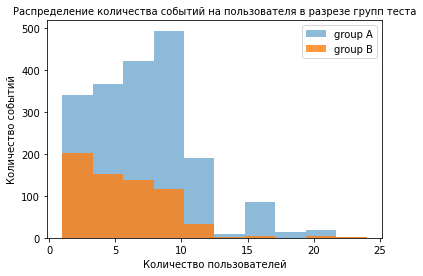

In [48]:
#Построим график распределения количества событий на пользователя в разрезе групп теста
plt.hist(recommender_system_test.query('group =="A"').groupby('user_id').agg({'event_name': 'count'}), alpha=0.5, label='A')
plt.hist(recommender_system_test.query('group =="B"').groupby('user_id').agg({'event_name': 'count'}), alpha=0.8, label='B')
plt.title('Распределение количества событий на пользователя в разрезе групп теста', fontsize=10)
plt.xlabel('Количество пользователей', fontsize=10)
plt.ylabel('Количество событий', fontsize=10)
plt.legend(['group A', 'group B']);

Судя по графику у группы А гораздо больше событий на пользователей. Это логично, ведь группа А более многочисленная нежели группа В. 

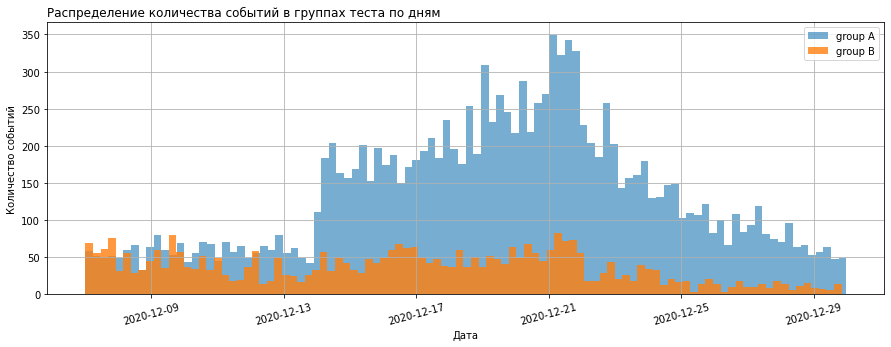

In [49]:
#Построим график динамики количества событий в группах теста по дням
plt.title('Распределение количества событий в группах теста по дням', loc='left')
recommender_system_test[recommender_system_test['group'] == 'A']['event_dt'].hist(bins=100, xrot=15,  figsize=(15, 5), alpha=0.6)
recommender_system_test[recommender_system_test['group'] == 'B']['event_dt'].hist(bins=100, xrot=15,  figsize=(15, 5), alpha=0.8)
plt.xlabel('Дата')                  
plt.ylabel('Количество событий') 
plt.legend(['group A', 'group B']);
plt.show()

In [50]:
marketing

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11
5,Black Friday Ads Campaign,"EU, CIS, APAC, N.America",2020-11-26,2020-12-01
6,Chinese New Year Promo,APAC,2020-01-25,2020-02-07
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10
9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11


Судя по данным из таблицы marketing, единственное маркетинговое мероприятие, которе пересекается с тестом - это Christmas & New Year Promo. Посмотрим влияет ли оно на количество логов в группах. 

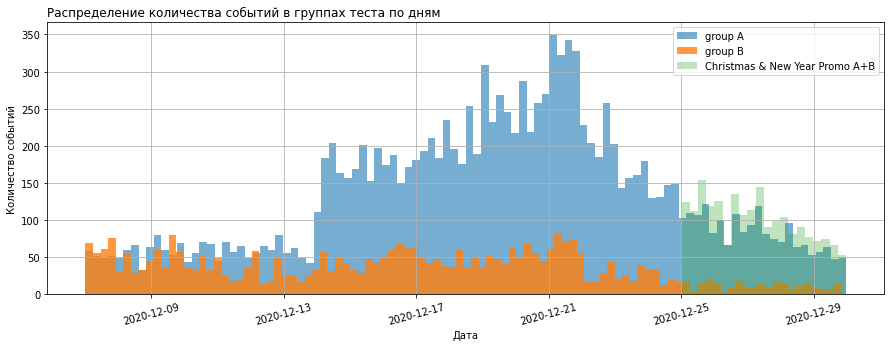

In [51]:
plt.title('Распределение количества событий в группах теста по дням', loc='left')
recommender_system_test[recommender_system_test['group'] == 'A']['event_dt'].hist(bins=100, xrot=15,  figsize=(15, 5), alpha=0.6)
recommender_system_test[recommender_system_test['group'] == 'B']['event_dt'].hist(bins=100, xrot=15,  figsize=(15, 5), alpha=0.8)
recommender_system_test[recommender_system_test['event_dt'] > '2020-12-25']['event_dt'].hist(bins=20, xrot=15, alpha=0.3)
plt.xlabel('Дата')                  
plt.ylabel('Количество событий') 
plt.legend(['group A', 'group B', 'Christmas & New Year Promo A+B']);
plt.show()

Как мы видим, промо акция Christmas & New Year Promo не сильно повлияла на количество логов. Она лишь незначительно снизила колисечтво событий в обеих группах. 

В тестовой группе пользовательская активность заметно снизилась. Однако судя по респределению логов по дням, в группе А мы видим сильное увеличение а затем спад активности. В группе В наоборот события протекают более равномерно. 

## Оценка A/B-теста

Для того чтобы оценить результат A/B-тестирования проверим статистическую разницу долей z-критерием.

In [52]:
#Составим таблицу с разделением пользователей по этапам воронки 
ab_test_users = recommender_system_test.pivot_table(index='event_name', columns='group',values='user_id',aggfunc='nunique').sort_values('A',ascending=False)
ab_test_users.drop(['login'], inplace=True, axis=0)
ab_test_users

group,A,B
event_name,,
product_page,1265,367
purchase,613,191
product_cart,589,184


In [53]:
# сохраним данные об участниках теста в переменную
test_users = recommender_system_test.groupby('group')['user_id'].nunique()
test_users = test_users.to_frame().reset_index()
test_users = test_users.set_index(test_users.columns[0])
test_users

,user_id
group,
A,1939
B,655


In [54]:
# функция для проверки статистической разницы долей z-критерием
def z_test(exp1, exp2, event, n):
    '''    
Функция принимает на вход два датафрейма с логами и по заданному событию попарно проверяет 
есть ли статистически значимая разница между долями пользователей, совершивших его в группе 1 и группе 2.

Входные параметры:
    - exp1, exp2 - датафреймы с логами
    - event - событие
    - alpfa - критический уровень статистической значимости
    - n - поправка Боннферони для критического уровня статистической значимости
    '''    
    # критический уровень статистической значимости зададим 0.05
    alpha = 0.05
    
    # критический уровень статистической значимости c поправкой Бонферрони
    bonferroni_alpha = alpha / n
    
    # число пользователей в группе A и группе B:
    a_users = ab_test_users.loc[event, exp1]
    b_users = ab_test_users.loc[event, exp2] 

    # число пользователей, совершивших событие в группе A и группе B
    a_success = test_users.loc[exp1, 'user_id'] 
    b_success = test_users.loc[exp2, 'user_id'] 

    # пропорции успехов в группах:
    pa = a_users/a_success
    pb = b_users/b_success
    
    # пропорция успехов в комбинированном датасете:
    p_combined = (a_users + b_users) / (a_success + b_success)

    # разница пропорций в датасетах
    difference = pa - pb 

    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / np.sqrt(p_combined * (1 - p_combined) * (1/a_users + 1/b_users))

    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1) 

    p_value = (1 - distr.cdf(abs(z_value))) * 2   #тест двусторонний, удваиваем результат
    
    print('Событие:', event)
    print('p-значение: ', p_value)
    
    if p_value < bonferroni_alpha:
        print('Отвергаем гипотезу: между долями есть разница')
    else:
        print(
        'Не получилось отвергнуть гипотезу, нет оснований считать доли разными')

Сопоставим доли по каждому событию между контрольными группами A и B;

Всего у нас 3 вида событий, следовательно для всех тестов мы вводим поправку Бонферрони bonferroni_alpha = alpha / 3, чтобы застраховать себя от ложного результата.


In [55]:
# проверим, есть ли статистически значимая разница между группами A и B:
for event in ab_test_users.index:
    z_test('A', 'B', event, 3)
    print()

Событие: product_page
p-значение:  0.0013015791861985537
Отвергаем гипотезу: между долями есть разница

Событие: purchase
p-значение:  0.5219653295958127
Не получилось отвергнуть гипотезу, нет оснований считать доли разными

Событие: product_cart
p-значение:  0.5541757406596661
Не получилось отвергнуть гипотезу, нет оснований считать доли разными



Таким образом, проверив статистическую значимость с помощью z-критерия, мы обнаружили, что между контрольной и тестовой группой есть разница в показателе product_page. В остальных показателях purchase и product_cart разницы в долях нет. 

## Итоговый вывод и рекомендации 

Таким образом, мы можем сделать вывод, что A/B-тестирование было проведено с многочисленными ошибками. Руководству нельзя опираться на результаты теста. Для того чтобы его переделать , следует более точно следовать ТЗ на начальных этапах проведения тестирования и соблюдать осторожность при сборе пользователей для тестирования. 